In [2]:
# Install Kaggle library
!pip install -q kaggle

# Make a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d mdkhurshidjahan01/figshare-brain-tumor-dataset

# Unzip the downloaded dataset
!unzip figshare-brain-tumor-dataset.zip -d brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/mdkhurshidjahan01/figshare-brain-tumor-dataset
License(s): Apache 2.0
figshare-brain-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  figshare-brain-tumor-dataset.zip
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_103192.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_104263.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_105758.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_106611.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_107584.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_111735.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_114652.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_115499.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_121515.png  
  inflating: brain_tumor_dataset/

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
171446536/171446536 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense

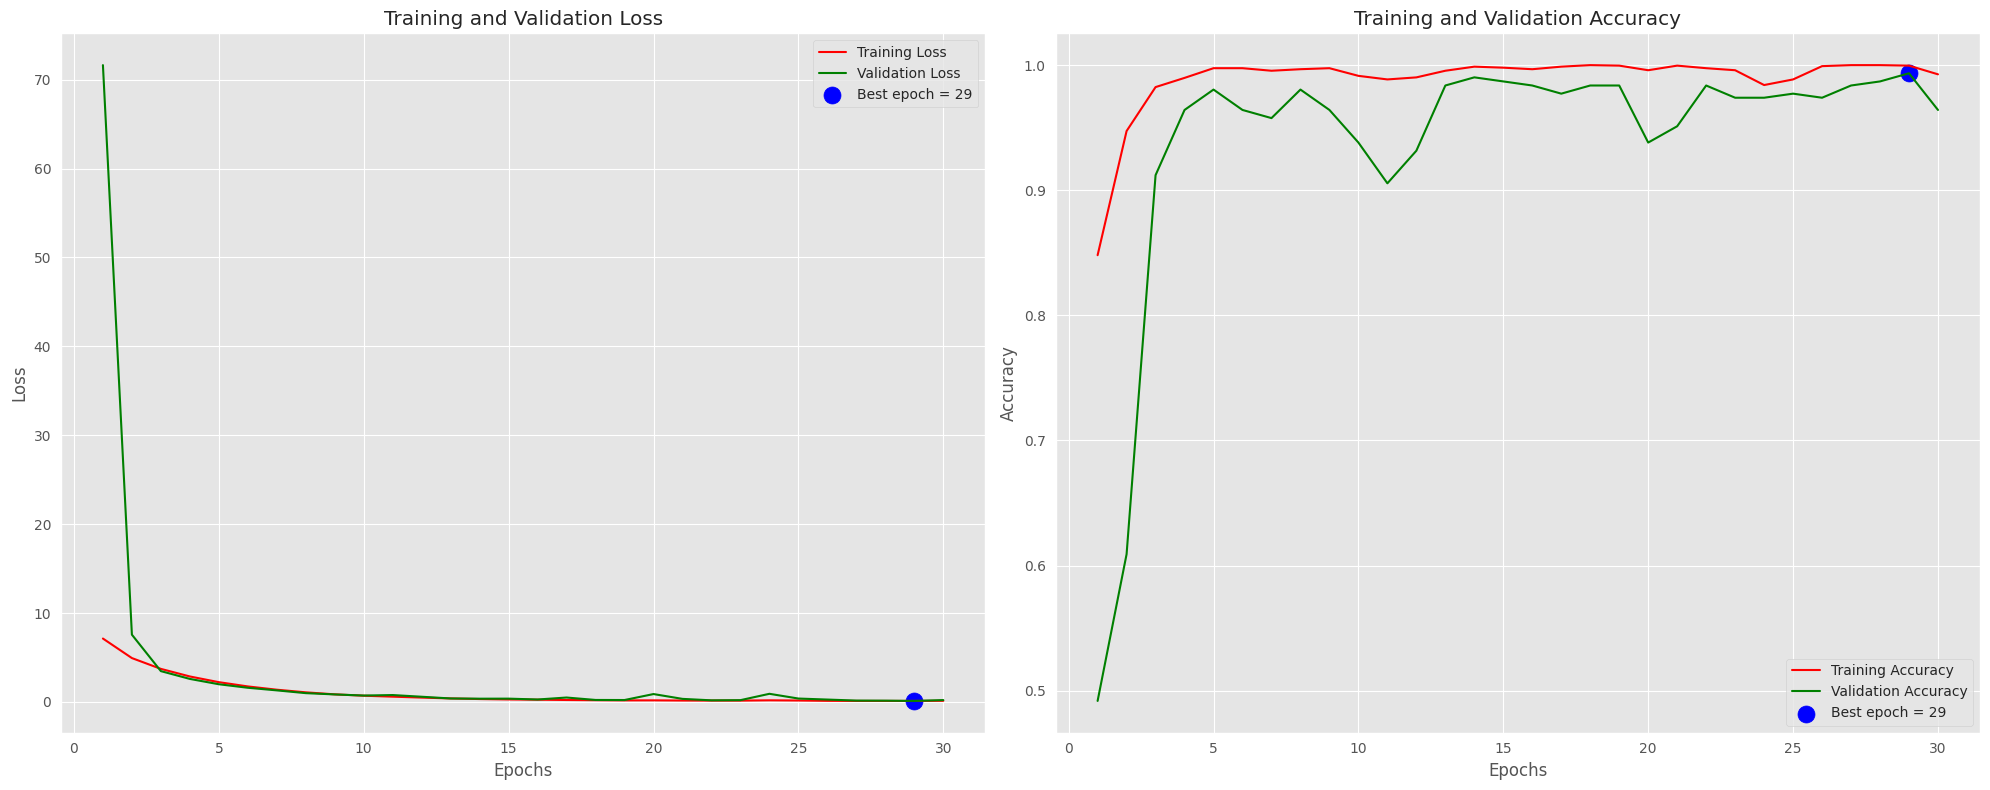

10/16 [=================>............] - ETA: 1s - loss: 0.2048 - accuracy: 0.9642

10/16 [=================>............] - ETA: 1s - loss: 0.1647 - accuracy: 0.9772

16/16 [==============================] - 3s 164ms/step - loss: 0.1647 - accuracy: 0.9772
Train Loss:  0.1356123387813568
Train Accuracy:  0.994140625
--------------------
Validation Loss:  0.20484426617622375
Validation Accuracy:  0.9641693830490112
--------------------
Test Loss:  0.16469503939151764
Test Accuracy:  0.9771987199783325
10/10 [==============================] - 5s 358ms/step


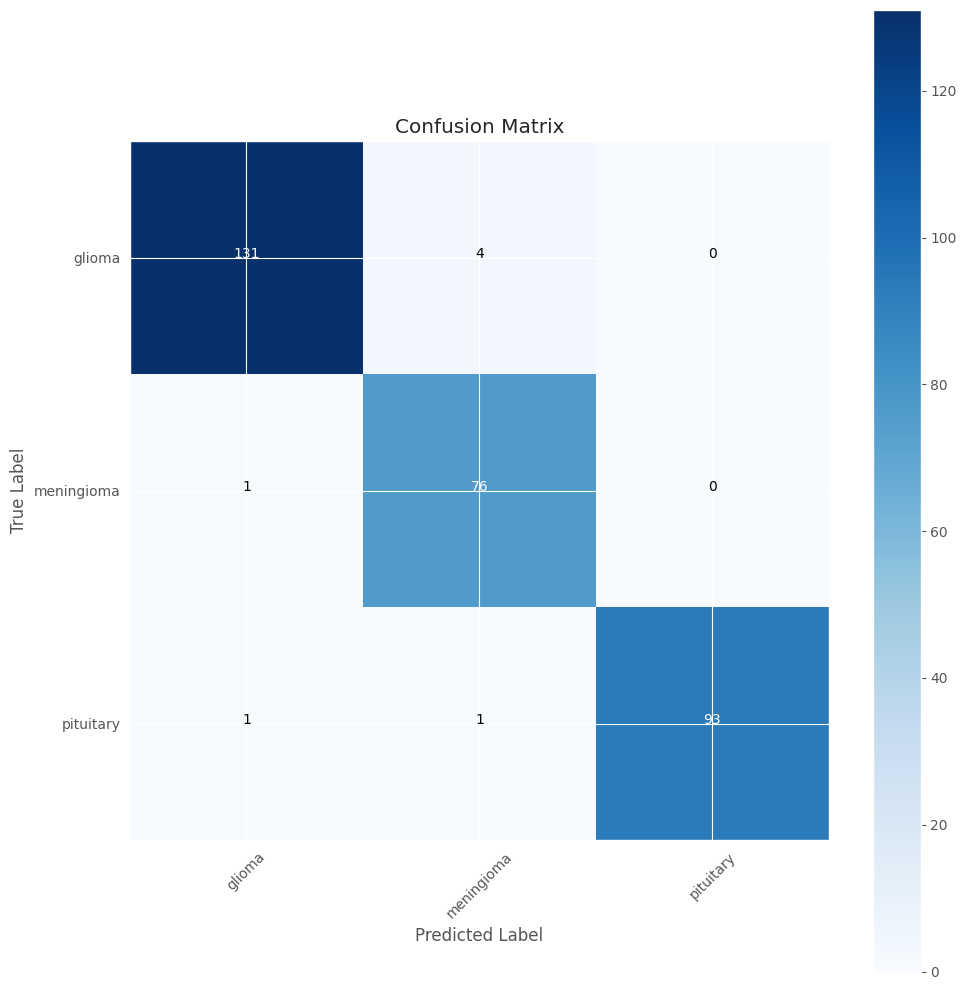

              precision    recall  f1-score   support

      glioma       0.98      0.97      0.98       135
  meningioma       0.94      0.99      0.96        77
   pituitary       1.00      0.98      0.99        95

    accuracy                           0.98       307
   macro avg       0.97      0.98      0.98       307
weighted avg       0.98      0.98      0.98       307



In [3]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '//content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

base_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback()])

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [ ]:
resnet 50

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense

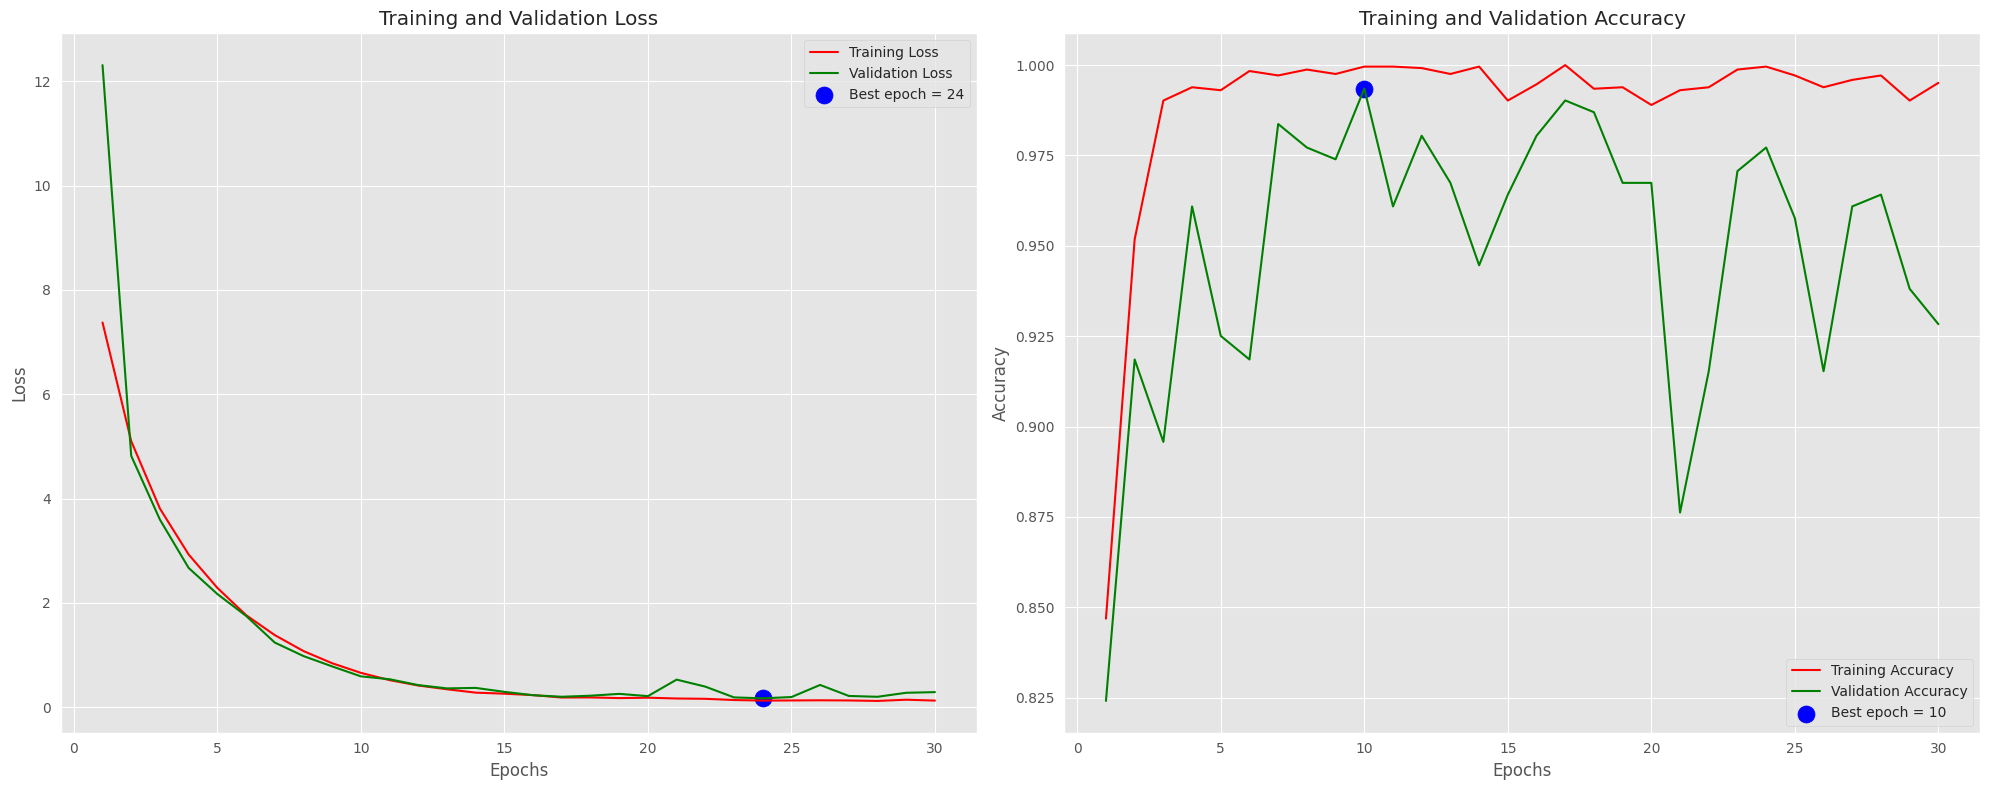

10/16 [=================>............] - ETA: 1s - loss: 0.2880 - accuracy: 0.9283

10/16 [=================>............] - ETA: 1s - loss: 0.3290 - accuracy: 0.9121

16/16 [==============================] - 3s 165ms/step - loss: 0.3290 - accuracy: 0.9121
Train Loss:  0.1766967475414276
Train Accuracy:  0.97265625
--------------------
Validation Loss:  0.2880193889141083
Validation Accuracy:  0.9283387660980225
--------------------
Test Loss:  0.32903072237968445
Test Accuracy:  0.9120520949363708
10/10 [==============================] - 4s 317ms/step


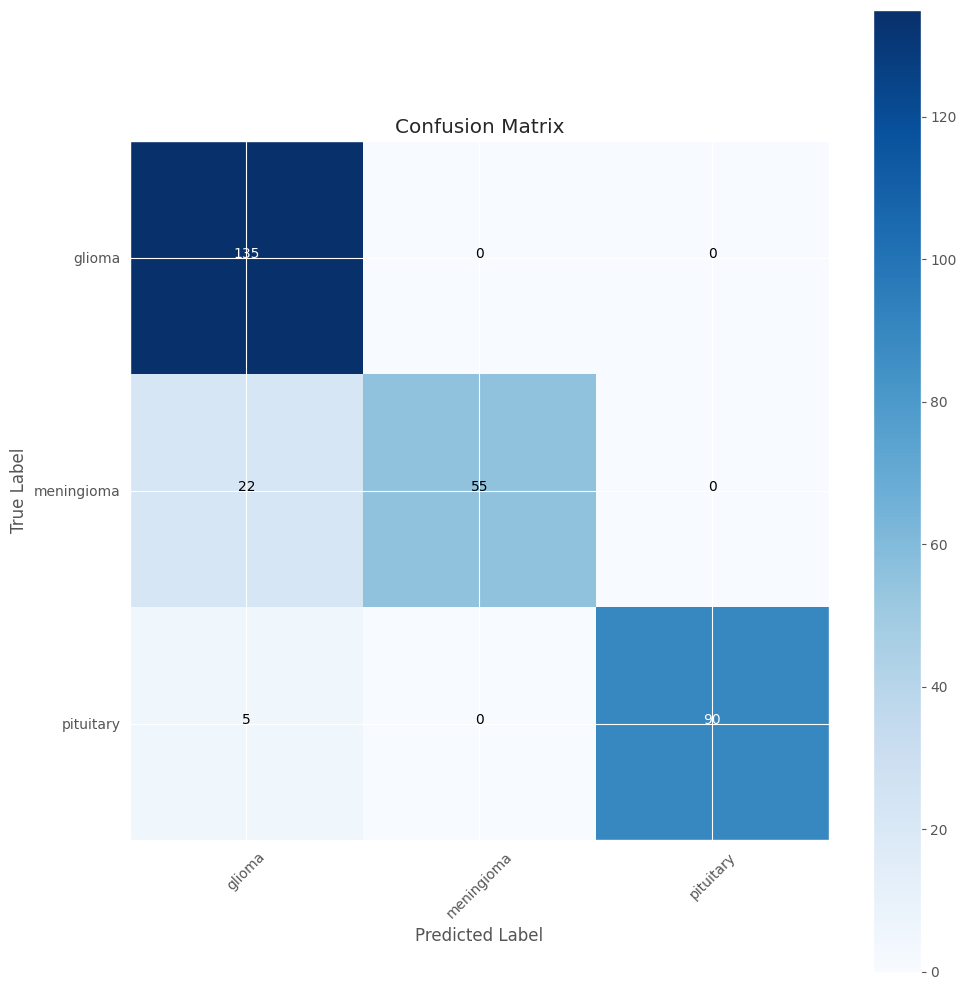

              precision    recall  f1-score   support

      glioma       0.83      1.00      0.91       135
  meningioma       1.00      0.71      0.83        77
   pituitary       1.00      0.95      0.97        95

    accuracy                           0.91       307
   macro avg       0.94      0.89      0.91       307
weighted avg       0.93      0.91      0.91       307



In [4]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback()])

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))